### DIABETIC RETINOPATHY CLASSIFICATION

#### 1. Import Libraries

In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

#### 2. Data Preprocessing, EDA, Visualization

In [33]:
train_path = r"C:\Users\srira\Downloads\907\DR Dataset\train"
valid_path = r"C:\Users\srira\Downloads\907\DR Dataset\valid"
test_path  = r"C:\Users\srira\Downloads\907\DR Dataset\test"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [34]:
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
valid_gen = valid_datagen.flow_from_directory(valid_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_gen = test_datagen.flow_from_directory(test_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', 
                                            shuffle=False)

Found 1925 images belonging to 5 classes.
Found 410 images belonging to 5 classes.
Found 412 images belonging to 5 classes.


C:\Users\srira\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


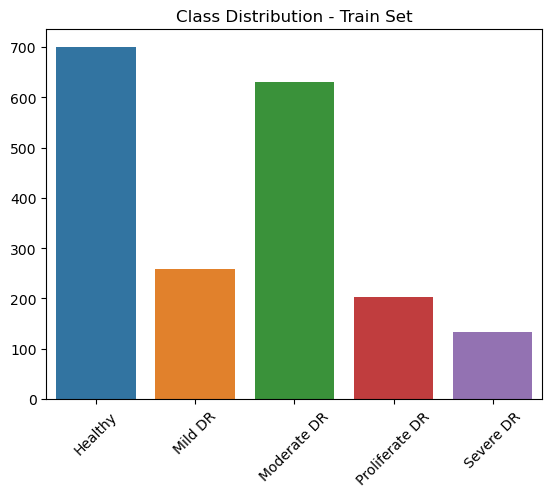

C:\Users\srira\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


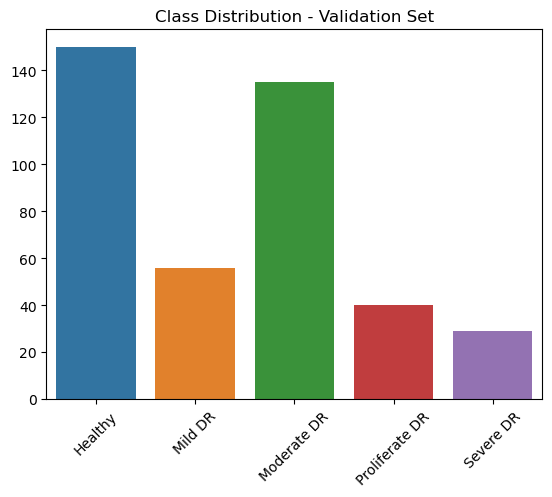

C:\Users\srira\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


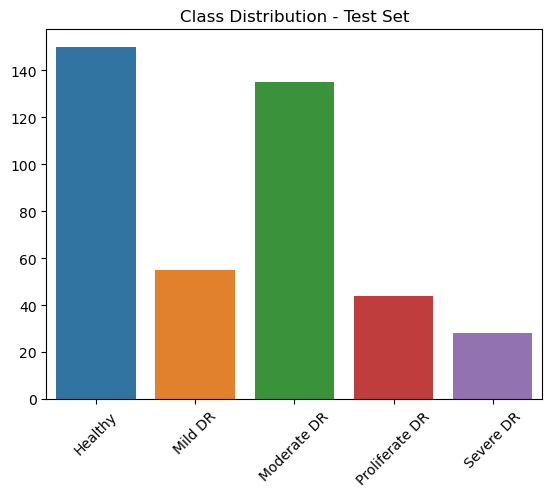

In [35]:
def plot_distribution(path, title):
    counts = {cls: len(os.listdir(os.path.join(path, cls))) for cls in os.listdir(path)}
    sns.barplot(x=list(counts.keys()), y=list(counts.values()))
    plt.title(f"Class Distribution - {title}")
    plt.xticks(rotation=45)
    plt.show()
plot_distribution(train_path, "Train Set")
plot_distribution(valid_path, "Validation Set")
plot_distribution(test_path, "Test Set")

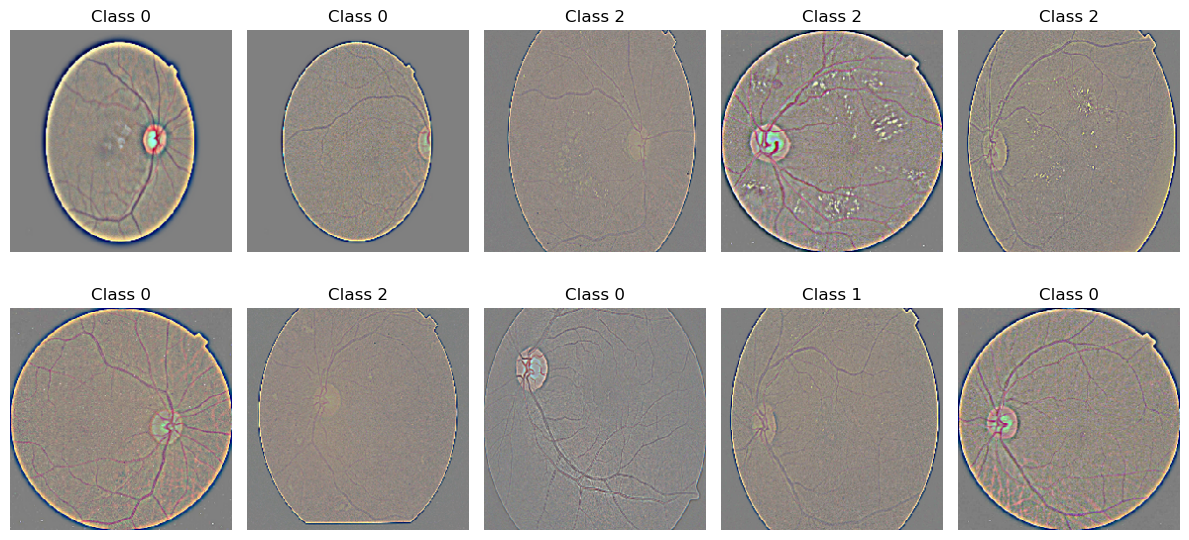

In [36]:
# Show sample images
def show_images(gen):
    x, y = next(gen)
    plt.figure(figsize=(12, 6))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.title(f"Class {np.argmax(y[i])}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_images(train_gen)

#### 4. Model Building

In [37]:
def squeeze_excite_block(input_tensor, ratio=16):
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Multiply()([input_tensor, se])
    return se

def resnet_block(x, filters, downsample=False):
    identity = x
    stride = 2 if downsample else 1

    x = Conv2D(filters, 3, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, 3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    x = squeeze_excite_block(x)

    if downsample:
        identity = Conv2D(filters, 1, strides=2, padding='same')(identity)
        identity = BatchNormalization()(identity)

    x = Add()([x, identity])
    x = ReLU()(x)
    return x

def build_se_resnet18(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = resnet_block(x, 64)
    x = resnet_block(x, 64)
    
    x = resnet_block(x, 128, downsample=True)
    x = resnet_block(x, 128)
    
    x = resnet_block(x, 256, downsample=True)
    x = resnet_block(x, 256)

    x = resnet_block(x, 512, downsample=True)
    x = resnet_block(x, 512)

    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

model = build_se_resnet18((224, 224, 3), train_gen.num_classes)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_40 (Conv2D)            │ (None, 112, 112, 64)      │           9,472 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_40        │ (None, 112, 112, 64)      │             256 │ conv2d_40[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_34 (ReLU)               │ (None, 112, 112, 64)      │               0 │ batch_normalization_40[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 56, 56, 64)        │               0 │ re_lu_34[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_41 (Conv2D)            │ (None, 56, 56, 64)        │          36,928 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_41        │ (None, 56, 56, 64)        │             256 │ conv2d_41[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_35 (ReLU)               │ (None, 56, 56, 64)        │               0 │ batch_normalization_41[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_42 (Conv2D)            │ (None, 56, 56, 64)        │          36,928 │ re_lu_35[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_42        │ (None, 56, 56, 64)        │             256 │ conv2d_42[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling2d_18   │ (None, 64)                │               0 │ batch_normalization_42[0]… │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_36 (Dense)              │ (None, 4)                 │             260 │ global_average_pooling2d_… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_37 (Dense)              │ (None, 64)                │             320 │ dense_36[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multiply_16 (Multiply)        │ (None, 56, 56, 64)        │               0 │ batch_normalization_42[0]… │
│                               │                           │                 │ dense_37[0][0]             │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 11,545,213 (44.04 MB)

 Trainable params: 11,535,613 (44.00 MB)

 Non-trainable params: 9,600 (37.50 KB)

#### 4. Model Training

In [38]:
checkpoint = ModelCheckpoint("se_resnet18_dr.h5", monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

In [39]:
history = model.fit(train_gen, validation_data=valid_gen, epochs=10, callbacks=[checkpoint, early_stop])

C:\Users\srira\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5583 - loss: 1.1862

61/61 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.5588 - loss: 1.1847 - val_accuracy: 0.3293 - val_loss: 1.7274
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.6379 - loss: 0.9218 - val_accuracy: 0.3293 - val_loss: 1.7167
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.6762 - loss: 0.8367 - val_accuracy: 0.3244 - val_loss: 1.6498
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.7463 - loss: 0.6909 - val_accuracy: 0.1366 - val_loss: 1.6110
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - accuracy: 0.8193 - loss: 0.5256 - val_accuracy: 0.1390 - val_loss: 2.5105
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9313 - loss: 0.2456

61/61 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.9311 - loss: 0.2463 - val_accuracy: 0.4049 - val_loss: 1.5292
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9543 - loss: 0.1705

61/61 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9542 - loss: 0.1711 - val_accuracy: 0.4805 - val_loss: 1.4617
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.9283 - loss: 0.2258 - val_accuracy: 0.3829 - val_loss: 1.5849
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.9641 - loss: 0.1379 - val_accuracy: 0.3512 - val_loss: 2.1062
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.9811 - loss: 0.0867 - val_accuracy: 0.4805 - val_loss: 2.2956


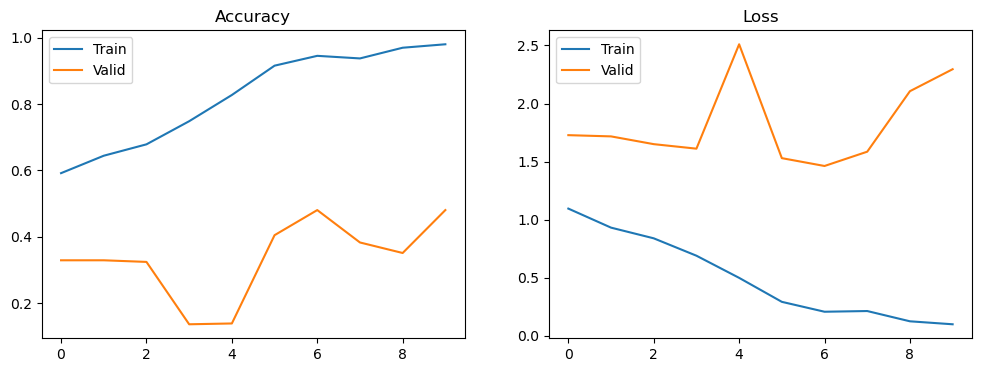

In [40]:
# Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Valid')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Valid')
plt.title('Loss')
plt.legend()
plt.show()

#### 5. Model Evaluation

In [41]:
# Predict
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 771ms/step


In [42]:
# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=list(test_gen.class_indices.keys())))

Classification Report:

                precision    recall  f1-score   support

       Healthy       0.62      0.83      0.71       150
       Mild DR       0.00      0.00      0.00        55
   Moderate DR       0.64      0.24      0.35       135
Proliferate DR       0.15      0.57      0.24        44
     Severe DR       0.00      0.00      0.00        28

      accuracy                           0.44       412
     macro avg       0.28      0.33      0.26       412
  weighted avg       0.45      0.44      0.40       412



C:\Users\srira\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\srira\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\srira\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Get ground truth and predictions
y_true = test_gen.classes
y_pred = model.predict(test_gen, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
# Precision, Recall, F1 Score (macro averages)
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
f1 = f1_score(y_true, y_pred_classes, average='macro')
# Print metrics
print("Evaluation Metrics on Test Data:")
print(f"Accuracy:  {accuracy:4f}")
print(f"Precision: {precision:4f}")
print(f"Recall:    {recall:4f}")
print(f"F1 Score:  {f1:4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 432ms/step
Evaluation Metrics on Test Data:
Accuracy:  0.441748
Precision: 0.283864
Recall:    0.327710
F1 Score:  0.260590


C:\Users\srira\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


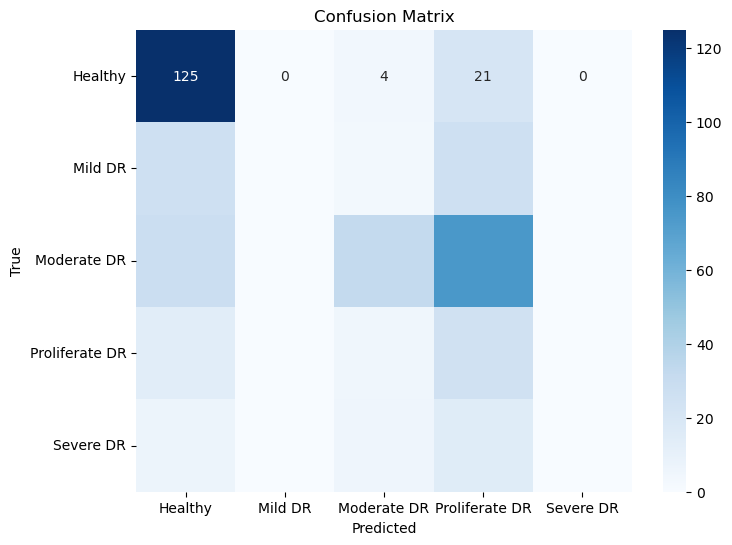

In [44]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys(), 
            cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

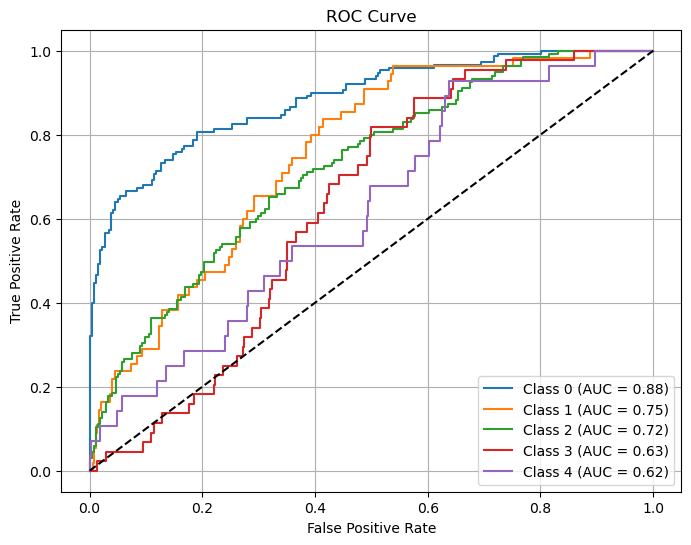

In [45]:
# ROC Curve
fpr = {}
tpr = {}
roc_auc = {}
n_classes = train_gen.num_classes
y_test_bin = tf.keras.utils.to_categorical(y_true, num_classes=n_classes)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(8,6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()